# Fitting a Line to Some Noisy Data
By: Griffin Hosseinzadeh (2019 April 17)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (You are free to change them to whatever you want, but be aware that your plots may look different than others'.)

<ErrorbarContainer object of 3 artists>

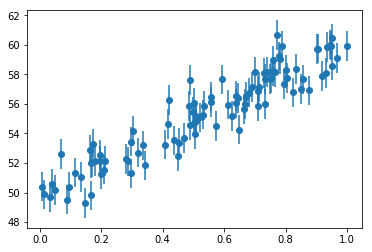

In [2]:
N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

x = np.random.rand(N)  # random values between 0 and 1
y = m * x + b + sigma * np.random.randn(N)  # random values from a Gaussian centered at 0 with standard deviation 1
dy = np.repeat(sigma, N)
plt.errorbar(x, y, dy, fmt='o')

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range.

In [3]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    if m_min < theta[0] < m_max:
        prob_m = 1./theta[0] # Log prior (not worrying about normalization)
    else:
        prob_m = 0.
    if b_min < theta[1] < b_max:
        prob_b = 1. # Uniform prior (not worrying about normalization)
    else:
        prob_b = 0.
    prob_total = prob_m*prob_b # Combined probability
    ln_prior = np.log(prob_total) # Log of the combined probability
    return ln_prior


def log_likelihood(theta, x, y, dy):
    y_fit = theta[0] * x + theta[1]
    gaussians = (y - y_fit)**2. / (2. * dy**2.) + np.log(dy) # Chi_Squared
    ln_like = -np.sum(gaussians)
    return ln_like


def log_posterior(theta, x, y, dy):
    ln_post = log_prior(theta) + log_likelihood(theta, x, y, dy) # From Bayes Theorem
    return ln_post

## Evaluate it on a Grid
Now that you have defined `log_posterior`, produce a grid of $m$ and $b$ values, and evaluate the posterior at each point on the grid. Plot the results using `plt.contour` (contour plot) or `plt.contourf` (filled contour plot).

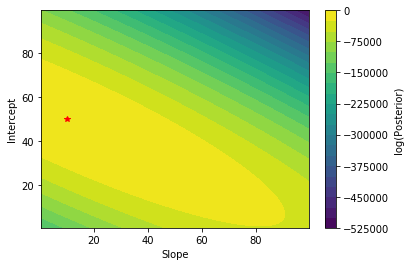

In [4]:
grid_spacing = 1.
m_range = np.arange(0.5, m_max, grid_spacing)
b_range = np.arange(0.5, b_max, grid_spacing)

num_points = len(m_range)
posterior_grid = np.empty((num_points, num_points))

# this is not an efficient way to do this;
# I'm just trying to make it very understandable
for i in range(num_points):
    for j in range(num_points):
        theta = [m_range[i], b_range[j]]
        posterior_grid[j, i] = log_posterior(theta, x, y, dy)

plt.contourf(m_range, b_range, posterior_grid, levels=20)
plt.xlabel('Slope')
plt.ylabel('Intercept')
cbar = plt.colorbar()
cbar.set_label('log(Posterior)')
plt.plot(m, b, 'r*')

Find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [5]:
i_max = np.argmin(np.min(posterior_grid, axis=0))
j_max = np.argmin(np.min(posterior_grid, axis=1))
print(f'm = {m_range[i_max]:.1f}, b = {b_range[j_max]:.1f}')
m_frac_err = (m_range[i_max] - m) / m
b_frac_err = (b_range[j_max] - b) / b
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

m = 99.5, b = 99.5
Δm/m = 8.950, Δb/b = 0.990


### Marginalize Over Each Parameter
Since you have a grid of points, it is easy to integrate (sum) along the rows and columns of the grid. Use this method to find the marginalized posterior for each parameter and plot the results. How do the peaks of these distributions compare to our input parameters? (Hint: use the `axis` keyword in `np.sum`.) (Another hint: integrate the probability, not the log of the probability.)

Text(0, 0.5, 'Marginalized Posterior')

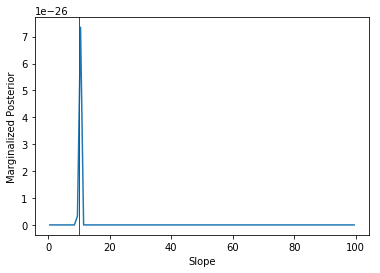

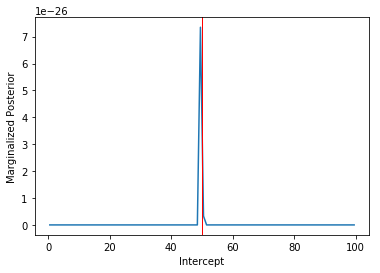

In [6]:
posterior_marginalized_m = np.sum(np.exp(posterior_grid), axis=0)
plt.figure()
plt.plot(m_range, posterior_marginalized_m)
plt.axvline(m, color='r', lw=1)
plt.xlabel('Slope')
plt.ylabel('Marginalized Posterior')

posterior_marginalized_b = np.sum(np.exp(posterior_grid), axis=1)
plt.figure()
plt.plot(b_range, posterior_marginalized_b)
plt.axvline(b, color='r', lw=1)
plt.xlabel('Intercept')
plt.ylabel('Marginalized Posterior')

## Evaluate it on a Random Sample (Monte Carlo)
Instead of evaluating the posterior at every point on the grid, it can be more efficient to evaluate it on a random sample of points within the parameter space. Generate some random points using the `np.random` module and evaluate the posterior at each one. Plot them and color code by the posterior. (Use the `c` parameter of `plt.scatter`.) How does this plot compare to the plot in the previous section?

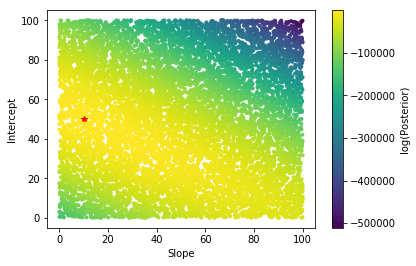

In [7]:
num_points = 100**2
m_random = np.random.rand(num_points) * (m_max - m_min) + m_min
b_random = np.random.rand(num_points) * (b_max - b_min) + b_min
posterior_random = np.empty(num_points)

# also very inefficient
for i in range(num_points):
    theta = [m_random[i], b_random[i]]
    posterior_random[i] = log_posterior(theta, x, y, dy)

plt.scatter(m_random, b_random, c=posterior_random, marker='.')
plt.xlabel('Slope')
plt.ylabel('Intercept')
cbar = plt.colorbar()
cbar.set_label('log(Posterior)')
plt.plot(m, b, 'r*')

As before, find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [8]:
i_max = np.argmin(posterior_random)
print(f'm = {m_random[i_max]:.1f}, b = {b_random[i_max]:.1f}')
m_frac_err = (m_random[i_max] - m) / m
b_frac_err = (b_random[i_max] - b) / b
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

m = 99.9, b = 99.8
Δm/m = 8.991, Δb/b = 0.996


Note that it's complicated to calculate the marginalized posteriors using this method. You have to do some kind of binning or interpolation. Don't worry about that for now.

## Take-Away Message
Both methods work, but the point is it's wasteful (and impossible for higher dimensons or large $N$) to be sampling the posterior when the probability density is $e^{-100000}$. Later, we will see a much more efficient sampling method.

## Other Things to Try
- Redo the experiment but with a different prior. How much do your results change? Try plotting the priors on top of your marginalized posteriors.
- Redo the experiment but with a much larger scatter. How well do you do? Now do the priors affect your results?
- Add another parameter to your model: the intrinsic scatter. See if you can recover the value you used to generate the noisy data.